In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_74.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_64.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_60.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_22.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_7.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_85.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_49.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_50.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_79.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_89.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_97.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_58.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/r

# SSL Method - Pseudo Labeling to predict ripeness of tomatoes
- ResNet
- Dropout
- L2 Regularization
- Learning Rate Scheduler

In [2]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset
from copy import deepcopy
from tqdm import tqdm
from PIL import Image

In [3]:
seed = 1

# Set device to use GPU if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
else: 
    device = torch.device('cpu')

torch.manual_seed(seed)

print(device)

cuda


In [4]:
# Enforce deterministic algorithms
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# DataLoader with worker_init_fn to ensure different seeds for each worker
def worker_init_fn(worker_id):
    np.random.seed(seed + worker_id)
    random.seed(seed + worker_id)
    torch.manual_seed(seed + worker_id)

## Data Setup

In [6]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
# Load labeled datasets
labeled_data_dir = '/kaggle/input/tomato-dataset-full/data/labeled-data'
labeled_dataset = datasets.ImageFolder(labeled_data_dir, transform=transform)

In [8]:
# Split labeled data into training and testing datasets
train_size = int(0.8 * len(labeled_dataset))
test_size = len(labeled_dataset) - train_size
train_dataset, test_dataset = random_split(labeled_dataset, [train_size, test_size])

In [9]:
# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, worker_init_fn=worker_init_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, worker_init_fn=worker_init_fn)

print('Num Labeled: ', len(labeled_dataset))

Num Labeled:  177


In [10]:
# Custom dataset class for unlabeled data
class UnlabeledDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = [os.path.join(data_dir, img) for img in os.listdir(data_dir) if img.endswith('.jpg') or img.endswith('.png')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

In [11]:
# Load unlabeled datasets
unlabeled_data_dir = '/kaggle/input/tomato-dataset-full/data/unlabeled-data'
unlabeled_dataset = UnlabeledDataset(unlabeled_data_dir, transform=transform)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=16, shuffle=True, num_workers=4, worker_init_fn=worker_init_fn)

print('Num Unlabeled: ', len(unlabeled_dataset))

Num Unlabeled:  996


## Define Model

In [12]:
# Define the ResNet model with dropout
class ResNetModel(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNetModel, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [13]:
# Initialize the model
model = ResNetModel(num_classes=2).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s] 


## Methods for Training

In [14]:
def generate_pseudo_labels(model, unlabeled_loader, threshold=0.9):
    model.eval()
    pseudo_labels = []

    with torch.no_grad():
        for inputs in tqdm(unlabeled_loader, desc='Generating Pseudo-Labels', leave=False):
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            max_probs, labels = torch.max(probs, dim=1)
            mask = max_probs > threshold
            pseudo_labels.extend([(input.cpu(), label.item()) for input, label, m in zip(inputs, labels, mask) if m])

    return pseudo_labels

In [15]:
class PseudoLabeledDataset(Dataset):
    def __init__(self, labeled_dataset, pseudo_labeled_data, transform=None):
        self.labeled_dataset = labeled_dataset
        self.pseudo_labeled_data = pseudo_labeled_data
        self.transform = transform

    def __len__(self):
        return len(self.labeled_dataset) + len(self.pseudo_labeled_data)

    def __getitem__(self, idx):
        if idx < len(self.labeled_dataset):
            return self.labeled_dataset[idx]
        else:
            image, label = self.pseudo_labeled_data[idx - len(self.labeled_dataset)]
            if self.transform and not isinstance(image, torch.Tensor):
                image = self.transform(image)
            return image, label

In [16]:
def train_model_with_pseudo_labels(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=35):
    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    train_accuracy = torchmetrics.Accuracy(task='binary').to(device)
    test_accuracy = torchmetrics.Accuracy(task='binary').to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        
        # Training phase
        model.train()
        running_loss = 0.0
        train_accuracy.reset()
        
        for inputs, labels in tqdm(train_loader, desc='Training', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            train_accuracy.update(preds, labels)
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = train_accuracy.compute().item()
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        test_accuracy.reset()
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc='Validation', leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                preds = torch.argmax(outputs, dim=1)
                test_accuracy.update(preds, labels)
                running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(test_loader.dataset)
        epoch_acc = test_accuracy.compute().item()
        test_losses.append(epoch_loss)
        test_accuracies.append(epoch_acc)
        print(f'Validation Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        scheduler.step()

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, train_losses, test_losses, train_accuracies, test_accuracies

## Train Model

In [17]:
# Instantiate model, loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Add L2 regularization
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [18]:
# Step 1: Train the initial model on the labeled data
initial_model, train_losses, test_losses, train_accuracies, test_accuracies = train_model_with_pseudo_labels(
    model, train_loader, test_loader, criterion, optimizer, scheduler)

Epoch 1/35


Training Loss: 0.6570 Acc: 0.8014


Validation Loss: 1.4235 Acc: 0.7500
Epoch 2/35


Training Loss: 0.3415 Acc: 0.8936


Validation Loss: 0.2673 Acc: 0.9722
Epoch 3/35


Training Loss: 0.1353 Acc: 0.9716


Validation Loss: 0.0000 Acc: 1.0000
Epoch 4/35


Training Loss: 0.1978 Acc: 0.9291


Validation Loss: 0.0215 Acc: 1.0000
Epoch 5/35


Training Loss: 0.1775 Acc: 0.9504


Validation Loss: 0.0058 Acc: 1.0000
Epoch 6/35


Training Loss: 0.1300 Acc: 0.9504


Validation Loss: 0.0040 Acc: 1.0000
Epoch 7/35


Training Loss: 0.0795 Acc: 0.9858


Validation Loss: 0.0059 Acc: 1.0000
Epoch 8/35


Training Loss: 0.1073 Acc: 0.9645


Validation Loss: 0.0024 Acc: 1.0000
Epoch 9/35


Training Loss: 0.2506 Acc: 0.9291


Validation Loss: 0.0150 Acc: 1.0000
Epoch 10/35


Training Loss: 0.1512 Acc: 0.9645


Validation Loss: 0.0486 Acc: 1.0000
Epoch 11/35


Training Loss: 0.0868 Acc: 0.9787


Validation Loss: 0.0377 Acc: 1.0000
Epoch 12/35


Training Loss: 0.0833 Acc: 0.9787


Validation Loss: 0.0265 Acc: 1.0000
Epoch 13/35


Training Loss: 0.0794 Acc: 0.9716


Validation Loss: 0.0217 Acc: 1.0000
Epoch 14/35


Training Loss: 0.0417 Acc: 0.9858


Validation Loss: 0.0175 Acc: 1.0000
Epoch 15/35


Training Loss: 0.0489 Acc: 0.9858


Validation Loss: 0.0154 Acc: 1.0000
Epoch 16/35


Training Loss: 0.0855 Acc: 0.9716


Validation Loss: 0.0161 Acc: 1.0000
Epoch 17/35


Training Loss: 0.0602 Acc: 0.9858


Validation Loss: 0.0136 Acc: 1.0000
Epoch 18/35


Training Loss: 0.0434 Acc: 0.9858


Validation Loss: 0.0126 Acc: 1.0000
Epoch 19/35


Training Loss: 0.0477 Acc: 0.9858


Validation Loss: 0.0113 Acc: 1.0000
Epoch 20/35


Training Loss: 0.0619 Acc: 0.9787


Validation Loss: 0.0086 Acc: 1.0000
Epoch 21/35


Training Loss: 0.0692 Acc: 0.9787


Validation Loss: 0.0080 Acc: 1.0000
Epoch 22/35


Training Loss: 0.0370 Acc: 0.9858


Validation Loss: 0.0068 Acc: 1.0000
Epoch 23/35


Training Loss: 0.0483 Acc: 0.9787


Validation Loss: 0.0073 Acc: 1.0000
Epoch 24/35


Training Loss: 0.0537 Acc: 0.9858


Validation Loss: 0.0072 Acc: 1.0000
Epoch 25/35


Training Loss: 0.0349 Acc: 0.9858


Validation Loss: 0.0064 Acc: 1.0000
Epoch 26/35


Training Loss: 0.0378 Acc: 0.9858


Validation Loss: 0.0073 Acc: 1.0000
Epoch 27/35


Training Loss: 0.0456 Acc: 0.9858


Validation Loss: 0.0067 Acc: 1.0000
Epoch 28/35


Training Loss: 0.0620 Acc: 0.9858


Validation Loss: 0.0067 Acc: 1.0000
Epoch 29/35


Training Loss: 0.0436 Acc: 0.9858


Validation Loss: 0.0063 Acc: 1.0000
Epoch 30/35


Training Loss: 0.0604 Acc: 0.9716


Validation Loss: 0.0065 Acc: 1.0000
Epoch 31/35


Training Loss: 0.0332 Acc: 0.9858


Validation Loss: 0.0058 Acc: 1.0000
Epoch 32/35


Training Loss: 0.0424 Acc: 0.9787


Validation Loss: 0.0058 Acc: 1.0000
Epoch 33/35


Training Loss: 0.0627 Acc: 0.9716


Validation Loss: 0.0077 Acc: 1.0000
Epoch 34/35


Training Loss: 0.0571 Acc: 0.9858


Validation Loss: 0.0065 Acc: 1.0000
Epoch 35/35


Training Loss: 0.0447 Acc: 0.9858


Validation Loss: 0.0065 Acc: 1.0000


In [19]:
# Step 2: Generate pseudo-labels using the trained model
pseudo_labels = generate_pseudo_labels(initial_model, unlabeled_loader)

print('Amount Pseudo Labels: ', len(pseudo_labels))

Amount Pseudo Labels:  946


In [20]:
# Combine labeled and pseudo-labeled data
combined_dataset = PseudoLabeledDataset(train_dataset, pseudo_labels, transform=transform)
combined_loader = DataLoader(combined_dataset, batch_size=16, shuffle=True, num_workers=4, worker_init_fn=worker_init_fn)

print('Combined Dataset:', len(combined_dataset))

Combined Dataset: 1087


In [21]:
# Step 3: Retrain the model using both labeled and pseudo-labeled data
combined_model = ResNetModel(num_classes=2).to(device)  # Reinitialize the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(combined_model.parameters(), lr=0.001, weight_decay=1e-4)  # Add L2 regularization
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

combined_model, combined_train_losses, combined_test_losses, combined_train_accuracies, combined_test_accuracies = train_model_with_pseudo_labels(
    combined_model, combined_loader, test_loader, criterion, optimizer, scheduler)

Epoch 1/35


Training Loss: 0.2721 Acc: 0.9098


Validation Loss: 0.0067 Acc: 1.0000
Epoch 2/35


Training Loss: 0.1270 Acc: 0.9522


Validation Loss: 0.1281 Acc: 0.9444
Epoch 3/35


Training Loss: 0.1037 Acc: 0.9641


Validation Loss: 0.0494 Acc: 1.0000
Epoch 4/35


Training Loss: 0.1225 Acc: 0.9614


Validation Loss: 0.0074 Acc: 1.0000
Epoch 5/35


Training Loss: 0.0818 Acc: 0.9742


Validation Loss: 0.0051 Acc: 1.0000
Epoch 6/35


Training Loss: 0.1256 Acc: 0.9614


Validation Loss: 0.0059 Acc: 1.0000
Epoch 7/35


Training Loss: 0.0615 Acc: 0.9807


Validation Loss: 0.0042 Acc: 1.0000
Epoch 8/35


Training Loss: 0.0921 Acc: 0.9669


Validation Loss: 0.0207 Acc: 1.0000
Epoch 9/35


Training Loss: 0.0560 Acc: 0.9798


Validation Loss: 0.0261 Acc: 1.0000
Epoch 10/35


Training Loss: 0.0269 Acc: 0.9917


Validation Loss: 0.0036 Acc: 1.0000
Epoch 11/35


Training Loss: 0.0133 Acc: 0.9945


Validation Loss: 0.0037 Acc: 1.0000
Epoch 12/35


Training Loss: 0.0146 Acc: 0.9926


Validation Loss: 0.0028 Acc: 1.0000
Epoch 13/35


Training Loss: 0.0101 Acc: 0.9963


Validation Loss: 0.0028 Acc: 1.0000
Epoch 14/35


Training Loss: 0.0093 Acc: 0.9972


Validation Loss: 0.0039 Acc: 1.0000
Epoch 15/35


Training Loss: 0.0415 Acc: 0.9945


Validation Loss: 0.0031 Acc: 1.0000
Epoch 16/35


Training Loss: 0.0105 Acc: 0.9963


Validation Loss: 0.0038 Acc: 1.0000
Epoch 17/35


Training Loss: 0.0113 Acc: 0.9963


Validation Loss: 0.0044 Acc: 1.0000
Epoch 18/35


Training Loss: 0.0097 Acc: 0.9954


Validation Loss: 0.0039 Acc: 1.0000
Epoch 19/35


Training Loss: 0.0085 Acc: 0.9963


Validation Loss: 0.0045 Acc: 1.0000
Epoch 20/35


Training Loss: 0.0061 Acc: 0.9972


Validation Loss: 0.0034 Acc: 1.0000
Epoch 21/35


Training Loss: 0.0049 Acc: 0.9991


Validation Loss: 0.0031 Acc: 1.0000
Epoch 22/35


Training Loss: 0.0067 Acc: 0.9972


Validation Loss: 0.0031 Acc: 1.0000
Epoch 23/35


Training Loss: 0.0072 Acc: 0.9972


Validation Loss: 0.0028 Acc: 1.0000
Epoch 24/35


Training Loss: 0.0083 Acc: 0.9963


Validation Loss: 0.0031 Acc: 1.0000
Epoch 25/35


Training Loss: 0.0051 Acc: 0.9982


Validation Loss: 0.0034 Acc: 1.0000
Epoch 26/35


Training Loss: 0.0059 Acc: 0.9982


Validation Loss: 0.0032 Acc: 1.0000
Epoch 27/35


Training Loss: 0.0060 Acc: 0.9982


Validation Loss: 0.0040 Acc: 1.0000
Epoch 28/35


Training Loss: 0.0079 Acc: 0.9963


Validation Loss: 0.0033 Acc: 1.0000
Epoch 29/35


Training Loss: 0.0044 Acc: 0.9991


Validation Loss: 0.0037 Acc: 1.0000
Epoch 30/35


Training Loss: 0.0056 Acc: 0.9982


Validation Loss: 0.0043 Acc: 1.0000
Epoch 31/35


Training Loss: 0.0095 Acc: 0.9963


Validation Loss: 0.0035 Acc: 1.0000
Epoch 32/35


Training Loss: 0.0067 Acc: 0.9982


Validation Loss: 0.0032 Acc: 1.0000
Epoch 33/35


Training Loss: 0.0059 Acc: 0.9982


Validation Loss: 0.0045 Acc: 1.0000
Epoch 34/35


Training Loss: 0.0042 Acc: 1.0000


Validation Loss: 0.0044 Acc: 1.0000
Epoch 35/35


Training Loss: 0.0077 Acc: 0.9972


Validation Loss: 0.0038 Acc: 1.0000


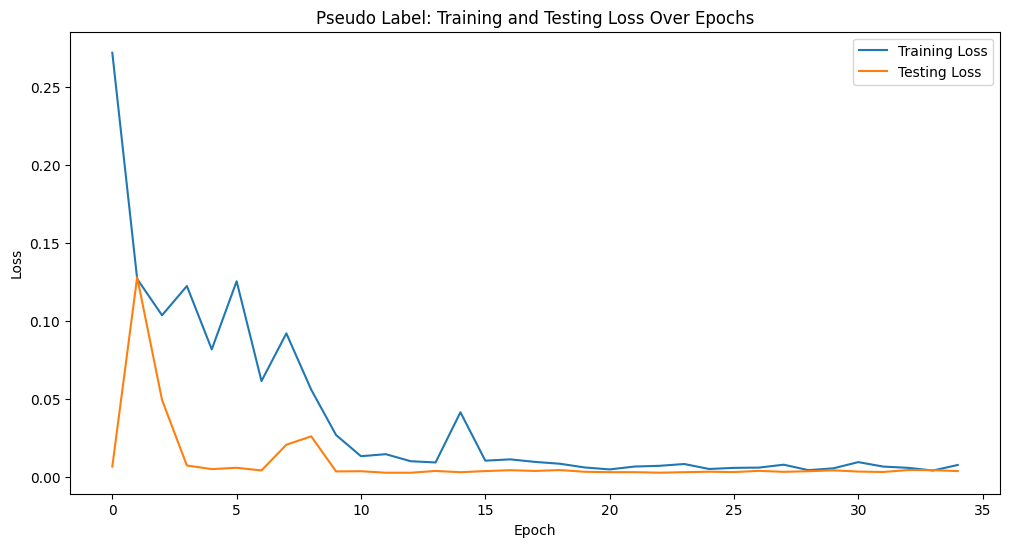

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(combined_train_losses, label='Training Loss')
plt.plot(combined_test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Pseudo Label: Training and Testing Loss Over Epochs')
plt.show()

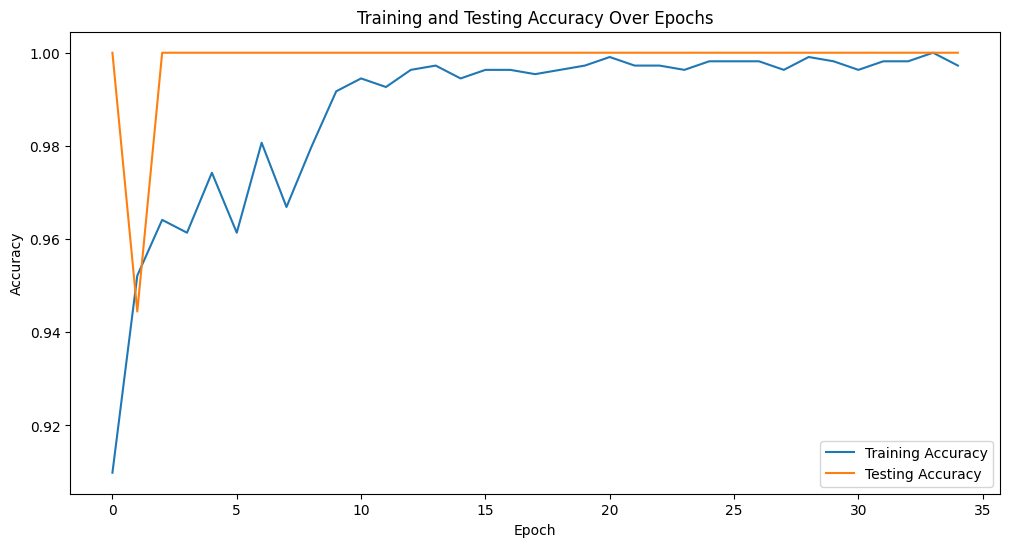

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(combined_train_accuracies, label='Training Accuracy')
plt.plot(combined_test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy Over Epochs')
plt.show()

## Validate

In [24]:
# Evaluate on validation set
validation_dir = '/kaggle/input/tomato-dataset-full/data/validation-data'
validation_dataset = datasets.ImageFolder(validation_dir, transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False, num_workers=4, worker_init_fn=worker_init_fn)

In [25]:
print('Validation Data Size: ', len(validation_dataset))

Validation Data Size:  2000


In [26]:
# Evaluate on validation set and display images
def evaluate_and_display(model, validation_loader, num_images=16):
    model.eval()
    val_accuracy = torchmetrics.Accuracy(task='binary').to(device)
    all_labels, all_preds, all_probs = [], [], []
    images = []
    num_samples = 0

    with torch.no_grad():
        for inputs, labels in tqdm(validation_loader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            val_accuracy.update(preds, labels)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            images.extend(inputs.cpu())
            num_samples += len(labels)

    val_acc = val_accuracy.compute().item()
    print(f'Validation Accuracy: {val_acc:.4f}')
    print(f'Number of samples validated on: {num_samples}')

    # Display images
    def unnormalize(img):
        mean = torch.tensor([0.485, 0.456, 0.406]).to(img.device)
        std = torch.tensor([0.229, 0.224, 0.225]).to(img.device)
        img = img * std[:, None, None] + mean[:, None, None]
        return img

    # Ensure num_images is not larger than the number of images
    if num_images > len(images):
        print(f"Batch size is smaller than num_images. Displaying {len(images)} images instead.")
        num_images = len(images)

    indices = random.sample(range(len(images)), num_images)
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()

    for ax, idx in zip(axes, indices):
        img = unnormalize(images[idx]).permute(1, 2, 0).numpy()
        ax.imshow(img)
        pred_class = "Riped" if all_preds[idx] == 0 else "Unriped"
        true_class = "Riped" if all_labels[idx] == 0 else "Unriped"
        confidence = np.max(all_probs[idx])
        ax.set_title(f'Predicted: {pred_class} ({confidence:.2f})\nActual: {true_class}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Validation Accuracy: 0.9650
Number of samples validated on: 2000


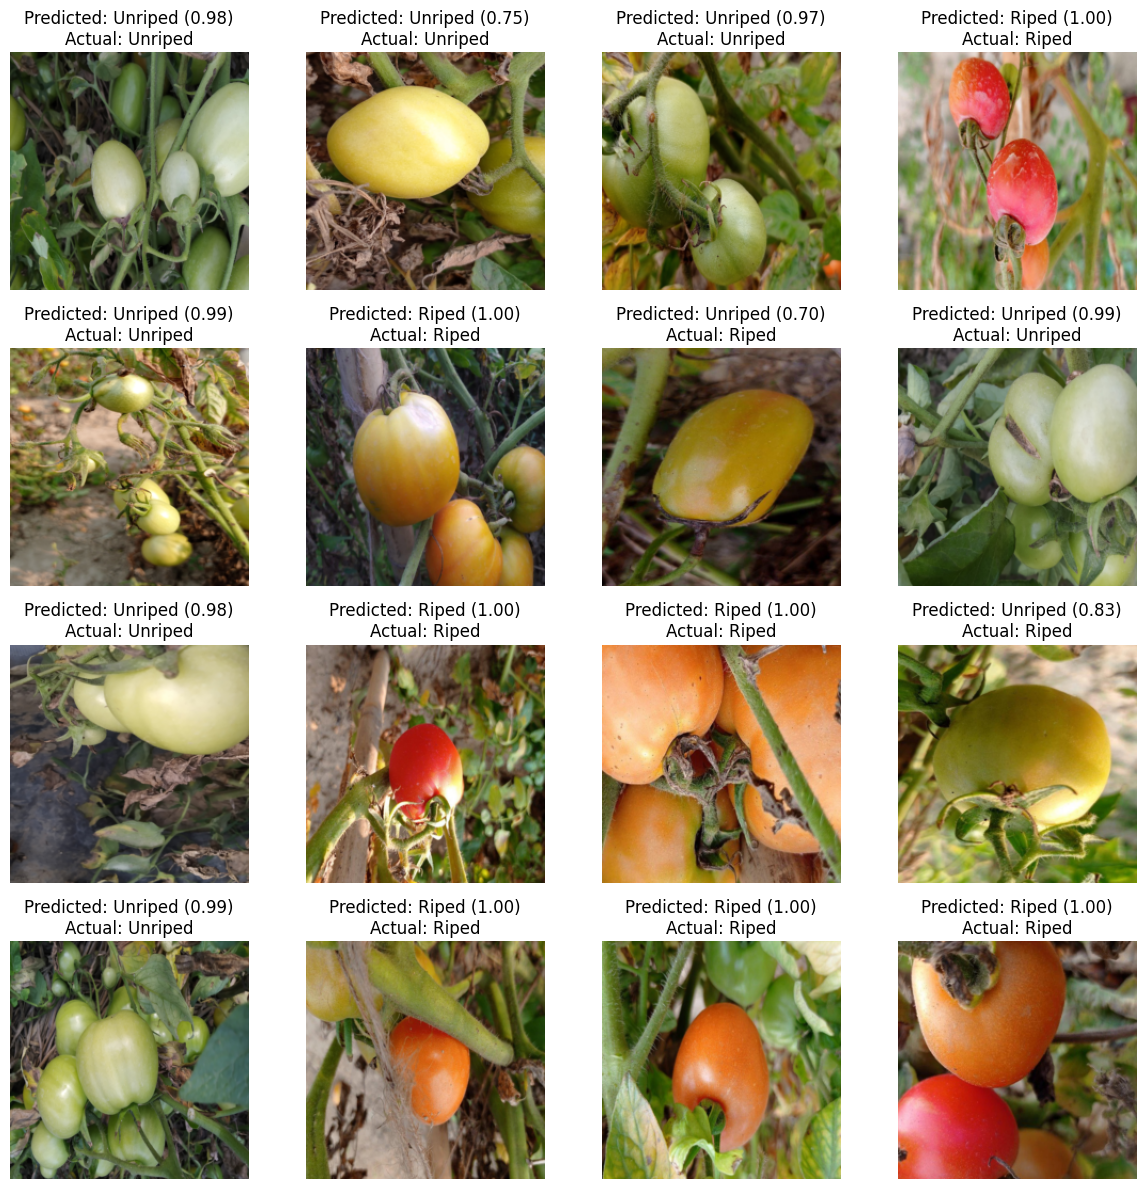

In [27]:
# Evaluate and display
evaluate_and_display(combined_model, validation_loader)